<table style="float:left; border:none">
   <tr style="border:none">
       <td style="border:none">  
           <img 
               src="" 
               style="width:10px"
           >
           </a>    
       </td>
   </tr>
</table>
<div style="float:right;"><h2>04. Whole population light gbm classifier</h2></div>

 <a id="top"></a> <br>
## Índice
1. [Entradas y Entregable](#1)<br>
    1.1. [Entradas del modelo](#11)<br>
    1.2. [Entregable](#12)<br>
2. [Carga de paquetes y datos](#2)<br>
    2.1. [Librerías y clases](#21)<br>
    2.2. [Lectura de datos](#22)<br>
    2.3. [Eliminación de valores nulos](#23)<br>
    2.4. [Binarización de variable delta_WHP](#24)<br>
    2.5. [Separación en train y test](#25)<br>
3. [Modelo](#3)<br>
    3.1. [Confección pipeline](#31)<br>
    3.2. [Optimización de hiperparámetros](#32)<br>
    3.3. [Entrenamiento del modelo](#33)<br>
    3.4. [Mejores Hiperparámetros](#34)<br>
4. [Evaluación del modelo](#4)<br>
    4.1. [Cálculo de métricas](#41)<br>
    4.2. [Matriz de confusión](#42)<br>
    4.3. [ROC Curve](#43)<br>
    4.4. [Precision-Recall curve](#44)<br>

***
<a id="1"></a> <br>
## 1. Entradas y Entregable

<a id="11"></a>
### 1.1. Entradas

|Tipo|Nombre|Descripción|Ubicación Lab|
|:-------|----------------|---------------------------------------------------|-------------------------------------|
|**csv**| `Dataset participantes.csv` | datos relacionados con los pozos al producirse una interferencia por la estimulación de un pozo hijo |`/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/`|

<a id="12"></a>
### 1.2. Entregable

**Archivo csv con las estimaciones de delta_WHP**

***
<a id="2"></a> <br>
## 2. Carga de paquetes y datos

<a id="21"></a>
### 2.1. Librerías y clases

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import recall_score, confusion_matrix, roc_curve, average_precision_score, precision_recall_curve, plot_precision_recall_curve, make_scorer, fbeta_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, binarize
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import lightgbm as lgb

import chardet

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Esta clase permite dropear columnas de un DataFrame dentro de un pipeline

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self  

<a id="22"></a> <br>
### 2.2. Lectura de datos

In [ ]:
# Detección automática de la codificación de los caracteres
with open("/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/Dataset participantes (corregido).csv", 'rb') as f:
    enc = chardet.detect(f.read())  # or readline if the file is large

# Lectura del csv
df = pd.read_csv("/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/Dataset participantes (corregido).csv",encoding = enc['encoding'], index_col=0)

df.sample(5)

,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO
ID_FILA,,,,,,,,,,,,,,,,
5977,Pozo 33-Pozo 42-39,Campo B,OIL,PAD-6,Pozo 33,39,Pozo 42,1443.509823,1443.379463,-19.399365,195.157060,0.0,NO,44.6,0.0,Abierto
5416,Pozo 237-Pozo 258-1,Campo F,OIL,PAD-61,Pozo 237,1,Pozo 258,601.301890,601.130505,-14.355452,91.269826,1.0,NO,43.1,0.0,Abierto
9146,Pozo 319-Pozo 312-15,Campo F,OIL,PAD-69,Pozo 319,15,Pozo 312,1178.268487,1176.499981,64.532344,164.055181,0.0,NO,63.3,0.0,Abierto
13975,Pozo 246-Pozo 378-34,Campo F,OIL,PAD-80,Pozo 246,34,Pozo 378,972.876921,971.345348,54.568483,265.530193,0.0,NO,247.7,0.0,Abierto
13198,Pozo 479-Pozo 97-10,Campo C,GAS,PAD-21,Pozo 479,10,Pozo 97,652.073049,651.935070,-13.413648,345.016665,0.0,NO,190.6,0.0,Abierto


In [ ]:
# Se cambia el tipo de datos de variables categóricas nominales de object a category
df = df.astype({"CAMPO": "category", "FLUIDO": "category", "PAD_HIJO": "category", "HIJO": "category",
                "ETAPA_HIJO": "category", "PADRE": "category", "LINEAMIENTO": "category", "ESTADO": "category"})
df.dtypes

ID_EVENTO        object
CAMPO          category
FLUIDO         category
PAD_HIJO       category
HIJO           category
ETAPA_HIJO     category
PADRE          category
D3D             float64
D2D             float64
DZ              float64
AZ              float64
#_BARRERAS      float64
LINEAMIENTO    category
WHP_i           float64
delta_WHP       float64
ESTADO         category
dtype: object

<a id="23"></a> <br>
### 2.3. Eliminación de valores nulos
**Dado que el modelo a desarrollar en el presente notebook será tomado como baseline, se eliminan los valores nulos para mayor practicidad**

In [ ]:
print("Cantidad de instancias totales =", df.shape[0])
# Eliminación de todos los valores nulos de dataset
df.dropna(inplace=True)
print("Cantidad de instancias sin valores nulos =", df.shape[0])

Cantidad de instancias totales = 26178
Cantidad de instancias sin valores nulos = 26178


<a id="24"></a> <br>
### 2.4. Binarización de variable delta_WHP

In [ ]:
# Se crea una nueva variable en donde se asigna valor 0 cuando delta_WHP = 0 y valor 1 cuando delta_WHP != 0
df["delta_WHP_binarized"] = df["delta_WHP"].apply(lambda val: 1 if val != 0 else 0)

<a id="25"></a> <br>
### 2.5. Separación en train y test

In [ ]:
# Selección de variable target
y = df.delta_WHP_binarized
# Selección de features
X = df.drop(["delta_WHP_binarized"], axis = 1)

# Separación en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,  stratify= y, random_state = 161)

# Verificación de distribución de variable targuet en train y test
print("Instancias de train \n", X_train.shape[0])
print("Instancias de test \n", X_test.shape[0])

Instancias de train 
 19633
Instancias de test 
 6545


***
<a id="#3"></a> <br>
## 3. Modelo

<a id="31"></a> <br>
### 3.1. Confección pipeline

In [ ]:
# Instanciado de estimador
light_gbm_class = lgb.LGBMClassifier(random_state = 45)

# Instanciado de pipeline
pipe = Pipeline([ ("ColumnDropper", ColumnDropper(["ID_EVENTO", "delta_WHP"])),
                  
                  ("column_transformer",ColumnTransformer([
                                        ("standard_scaler", StandardScaler(), 
                    ["D3D", "D2D", "DZ", "AZ", "WHP_i", "#_BARRERAS"])])),
                                 
                                 ("light_gbm_class", light_gbm_class)])

<a id="32"></a> <br>
### 3.2. Optimización de hiperparámetros

In [ ]:
# Creacion de score f2 
ftwo_scorer = make_scorer(fbeta_score, beta=2)

In [ ]:
# Optimización de hiperparámetros del modelo con grid search y cross validation

kfolds=StratifiedKFold(n_splits=3,shuffle=True, random_state=42)

params_grid = { 
                "light_gbm_class__max_depth" : [50, 100],
                "light_gbm_class__learning_rate": [ 0.01, 0.1,],
                "light_gbm_class__n_estimators" : [ 300, 500],
               'light_gbm_class__feature_fraction':[0.8],
               'light_gbm_class__min_data_in_leaf':[100]

               }

model = GridSearchCV (pipe, params_grid,cv=kfolds, n_jobs = -1, scoring = ftwo_scorer , refit = True)

<a id="33"></a> <br>
### 3.3. Entrenamiento del modelo

In [ ]:
# Seteado de parámetros de entrenamiento
fit_params={"light_gbm_class__categorical_feature": "auto" }

# Entrenamiento del modelo
model.fit(X_train,y_train, **fit_params)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('ColumnDropper',
                                        ColumnDropper(columns=['ID_EVENTO',
                                                               'delta_WHP'])),
                                       ('column_transformer',
                                        ColumnTransformer(transformers=[('standard_scaler',
                                                                         StandardScaler(),
                                                                         ['D3D',
                                                                          'D2D',
                                                                          'DZ',
                                                                          'AZ',
                                                                          'WHP_i',
                                                              

<a id="34"></a> <br>
### 3.4. Mejores hiperparámetros

In [ ]:
# Mejores hiperparámetros obtenidos por cross validation y grid search

model.best_params_

{'light_gbm_class__feature_fraction': 0.8,
 'light_gbm_class__learning_rate': 0.1,
 'light_gbm_class__max_depth': 50,
 'light_gbm_class__min_data_in_leaf': 100,
 'light_gbm_class__n_estimators': 500}

***
<a id="#4"></a> <br>
## 4. Evaluación del modelo

<a id="41"></a> <br>
### 4.1. Cálculo de métricas

In [ ]:
# recall_score
recall_train = recall_score(y_train, model.predict(X_train))
print("Recall train = ", recall_train)
recall_test = recall_score(y_test, model.predict(X_test))
print("Recall test = ", recall_test)

Recall train =  0.9266211604095563
Recall test =  0.6798975672215108


In [ ]:
model_predict_proba_train = model.predict_proba(X_train)
model_pred_train = binarize(model_predict_proba_train, threshold = 0.05)[:,1]

model_predict_proba_test = model.predict_proba(X_test)
model_pred_test = binarize(model_predict_proba_test, threshold = 0.05)[:,1]

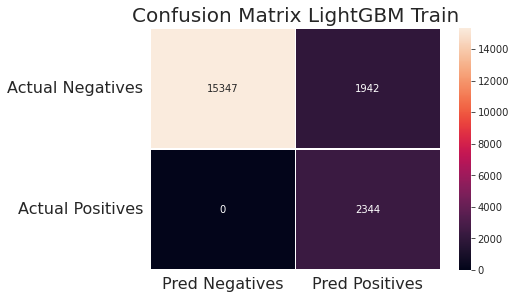

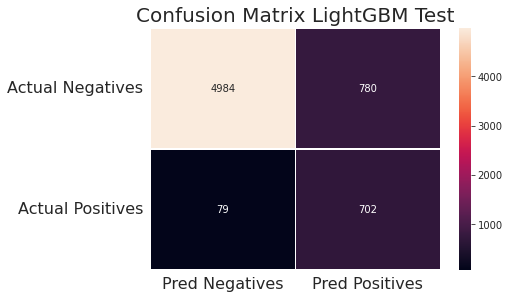

In [ ]:
# Matriz de confusión para modelo
conf_matrix = confusion_matrix(y_train, model_pred_train)
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix LightGBM Train", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()

conf_matrix = confusion_matrix(y_test, model_pred_test)
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix LightGBM Test", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()

<a id="42"></a> <br>
### 4.2. Matriz de confusión

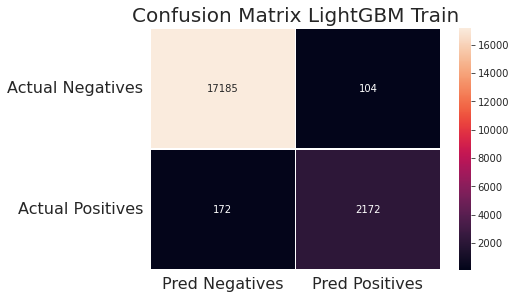

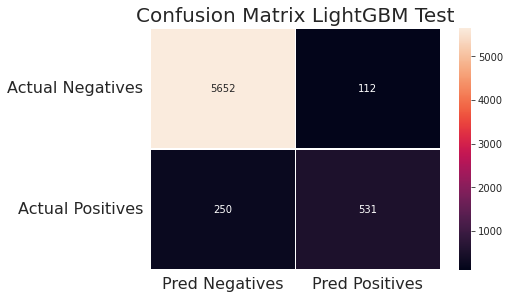

In [ ]:
# Matriz de confusión para modelo
conf_matrix = confusion_matrix(y_train,  model.predict(X_train))
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix LightGBM Train", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()

conf_matrix = confusion_matrix(y_test,  model.predict(X_test))
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix LightGBM Test", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()

<a id="43"></a> <br>
### 4.3. ROC Curve

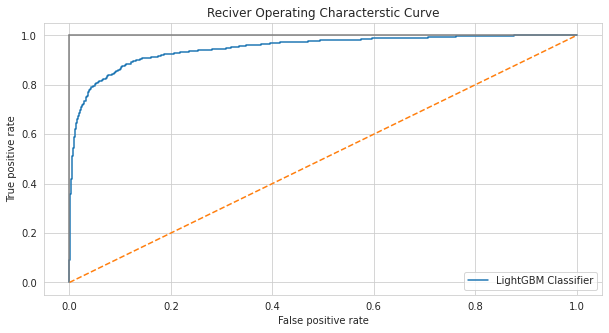

In [ ]:
# Obtencion de predicciones para graficar curva ROC
probsdmodel = model.predict_proba(X_test)
predsdmodel = probsdmodel[:,1]

lr_false_positive_rate,lr_true_positive_rate,lr_threshold = roc_curve(y_test,predsdmodel)


# Grafico curva ROC
sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(lr_false_positive_rate,lr_true_positive_rate,label='LightGBM Classifier')

plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

<a id="44"></a> <br>
### 4.4. Precision-Recall Curve

In [ ]:
sample_weight en el fit, le paso weights del dato del entrenamiento

SyntaxError: ignored

0.8207707587590165


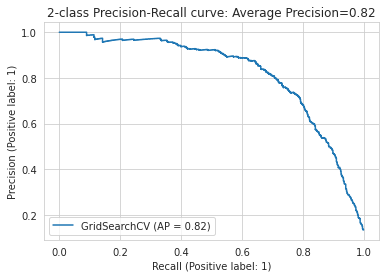

In [ ]:
# Curva Precision-Recall
average_precision = average_precision_score(y_test, predsdmodel)

print(average_precision)

disp = plot_precision_recall_curve(model, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'Average Precision={0:0.2f}'.format(average_precision));

In [ ]:
import plotly.express as px

y_true = y_test
y_pred =  model.predict_proba(X_test)[:,1]

scored_df = pd.DataFrame()
scored_df['target'] = y_test
scored_df['1'] = y_pred
scored_df.index = y_true.index
scored_df.sample(2)

# Define paths de y_true, y_pred_proba
#path_y_true = "tmp/test_set.gz"
y_true_col = "target"

#path_y_pred = "tmp/y_pred_proba_lgbm.csv"
y_pred_col = "1"

#id_col = "cus_cust_id_borrower"

# Define función para unificar target y predicción
def get_scored_df(path_y_true, path_y_pred):
    labels = pd.read_csv(path_y_true, usecols=[id_col, y_true_col])
    preds = pd.read_csv(path_y_pred)
    scored = pd.merge(left=labels, right=preds, left_index=True, right_index=True)
    scored[y_pred_col] = scored[y_pred_col].apply(lambda x: round(x*100, 2))
    return scored

# Armado de dataframe scoreado
#scored_df = get_scored_df(path_y_true, path_y_pred)
scored_df.sort_values(y_pred_col, ascending=False, inplace=True, ignore_index=True)
scored_df

# Reemplaza separador decimal
to_hr = lambda x: "{:,}".format(x).replace(",", ".")

# Preprocesamiento del df scoreado + métricas
pps = [round(x, 3) for x in np.arange(0.001, 1.001, 0.001)]
precisions = list()
recalls = list()
kss = list()
msgs_prec = list()
msgs_recall = list()
msgs_ks = list()
total_clientes = scored_df.shape[0]
total_0s = scored_df[y_true_col].value_counts()[0]
total_1s = scored_df[y_true_col].value_counts()[1]
for pp in pps:
    slice_idx = int(total_clientes * pp)
    current_df = scored_df.loc[:slice_idx-1, :]
    try:
      current_0s = current_df[y_true_col].value_counts()[0]
    except:
      current_0s = 0
    try:
      current_1s = current_df[y_true_col].value_counts()[1]
    except:
      current_1s = 0
    precisions.append(current_1s / slice_idx)
    msgs_prec.append("({} de {})".format(to_hr(current_1s), to_hr(slice_idx)))
    gain_1 = current_1s / total_1s
    recalls.append(gain_1)
    msgs_recall.append("({} de {})".format(to_hr(current_1s), to_hr(total_1s)))
    kss.append(gain_1 - (current_0s / total_0s))

# Genera df con métricas
metrics_df = pd.DataFrame({
    "PP": pps,
    "PRECISION": precisions,
    "RECALL": recalls,
    "KS": kss,
    "msg_PRECISION": msgs_prec,
    "msg_RECALL": msgs_recall})

metrics_df

# Calcula métricas
dfs = list()
for c, new_name in [("PRECISION", "PRECISION"),
                    ("RECALL", "RECALL"),
                    ("KS", "KS")]:
    cdf = metrics_df[["PP", c]].copy()
    cdf.rename(columns={c: "VALOR"}, inplace=True)
    cdf["METRICA"] = new_name
    cdf["msg"] = metrics_df["msg_" + c] if c != "KS" else ""
    dfs.append(cdf)
    
# Unifica df scoreado + métricas para plotear
plot_df = pd.concat(dfs)
for c in ["PP", "VALOR"]:
    plot_df[c] = plot_df[c].apply(lambda x: x*100)

# Plotea
fig = px.line(
    plot_df, x="PP", y="VALOR", color="METRICA",
    width=1000, height=700, text=plot_df["msg"],
    hover_data=["METRICA"])

fig.update_layout(
    hovermode="x",
    font_size=15,
    legend_title_text=None,
    paper_bgcolor="rgba(0, 0, 0, 0)",
    title=dict(text="Modelo Conversión TC MLB - Métricas", font_size=25),
    xaxis=dict(range=[0, 100], title=dict(text="Población (ordenada de mayor a menor score)"), dtick=10),
    yaxis=dict(range=[0, 100], title=dict(text="Valor de la métrica"), dtick=10),
    font=dict(color="black"),
    hoverlabel=dict(font_size=16,))

fig.update_traces(mode="lines", hovertemplate="%{y:.1f}% %{text}")
fig.update_xaxes(showspikes=True, spikecolor="gray", spikesnap="cursor", spikemode="across", ticksuffix="%")
fig.update_yaxes(ticksuffix="%")
fig.update_layout(spikedistance=1000, hoverdistance=100)
fig.show()